In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.4 MB/s 
     |████████████████████████████████| 163 kB 67.3 MB/s 
     |████████████████████████████████| 7.6 MB 48.3 MB/s 


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 8.1 MB/s 
     |████████████████████████████████| 212 kB 55.1 MB/s 
     |████████████████████████████████| 95 kB 6.1 MB/s 
     |████████████████████████████████| 115 kB 70.7 MB/s 
     |████████████████████████████████| 127 kB 72.5 MB/s 
     |████████████████████████████████| 115 kB 67.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [ ]:
import shutil
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import datasets
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering
from datasets import load_dataset
from keras_preprocessing.sequence import pad_sequences

In [ ]:
#讀檔
squad_v2 = False
datasets = load_dataset( "squad_v2"  if squad_v2 else  "squad" )

#將資料格式調整為DataFrame
def convert_df(ori_data):
  data=[]
  for question_and_answers in ori_data:
    question=question_and_answers['question']
    context=question_and_answers['context']
    answr_text=question_and_answers['answers']['text'][0]
    answr_start=question_and_answers['answers']['answer_start'][0]
    answr_end=answr_start+len(answr_text)
    data.append({
        "question":question,
        "context":context,
        "answr_text":answr_text,
        "answr_start":answr_start,
        "answr_end":answr_end
    })
  return pd.DataFrame(data)

#將資料拆分成訓練、驗證、測試集
df_train=convert_df(datasets[ "train" ]).iloc[0:2000,:]
df_valid=convert_df(datasets[ "validation" ]).iloc[0:500,:]
df_valid,df_test=train_test_split(df_valid,test_size=0.5)
df_valid=df_valid.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#資料預訓練模型
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def Checklength(data):
  k=[]
  for i in range(len(data)):
    question=data.loc[i]['question']
    context	=data.loc[i]['context']
    k.append(len(tokenizer(question, context)["input_ids"]))
  return(max(k))

#檢查最長數據大小
print(Checklength(df_train),Checklength(df_valid),Checklength(df_test))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

451 442 437


In [ ]:
EPOCHS=2
input_max_len=512
TRAIN_BATCH_SIZE=4
VALID_BATCH_SIZE=4
TEST_BATCH_SIZE=4

In [ ]:
one=df_train.iloc[10,:]
print("Question : {}".format(one['question']))
print("Context : {}".format(one['context']))
print("Answer : {}".format(one['answr_text']))
print("Start : {}".format(one['answr_start']))
print("End : {}".format(one['answr_end']))

Question : Where is the headquarters of the Congregation of the Holy Cross?
Context : The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.
Answer : Rome
Start : 119
End : 123


In [ ]:
inputs = tokenizer(one.question, one.context,max_length= 512,padding='max_length',return_offsets_mapping=True,return_token_type_ids=True,return_tensors="pt")

In [ ]:
#原始答案起始與結束位置
start=one['answr_start']
end=one['answr_end']

#修正答案位置
sequence_ids=inputs['token_type_ids'].flatten()
idx = 0
while sequence_ids[idx] == 0 :
  idx += 1
  if sequence_ids[idx] ==1:
        break
context_start = idx
try:
  while sequence_ids[idx] == 1:
        idx += 1
except:
  idx -= 1
#context_end = idx - 1
context_end = idx - 2
print(context_start,context_end)


start_positions = []
end_positions = []
start_char=start
end_char=end
offset=inputs["offset_mapping"][0]
if offset[context_start][0].item() > start_char or offset[context_end][1].item() < end_char:
  start_positions.append(0)
  end_positions.append(0)
else:
  # Otherwise it's the start and end token positions
  idx = context_start
  while idx <= context_end and offset[idx][0] <= start_char:
    idx += 1
  start_positions.append(idx - 1)

  idx = context_end
  while idx >= context_start and offset[idx][1] >= end_char:
    idx -= 1
  end_positions.append(idx+1)
start_rel = start_positions[0]
end_rel = end_positions[0]
print(start_rel,end_rel)
print(tokenizer.decode(inputs['input_ids'][0][start_rel:end_rel+1]))

14 158
36 36
rome


In [ ]:
#1004original
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, input_max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.input_max_len = input_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data_row=self.df.iloc[index]

        inputs = self.tokenizer(
          data_row['question'],
          data_row['context'],
          max_length= self.input_max_len,
          padding='max_length',
          #回傳答案相對位置
          return_offsets_mapping=True,
          return_token_type_ids=True,
          return_tensors="pt"
        )

        #原始答案起始與結束位置
        start=data_row['answr_start']
        end=data_row['answr_end']

        #修正答案位置
        sequence_ids=inputs['token_type_ids'].flatten()
        idx = 0
        while sequence_ids[idx] == 0 :
          idx += 1
          if sequence_ids[idx] ==1:
            break
        context_start = idx
        try:
          while sequence_ids[idx] == 1:
              idx += 1
        except:
              idx -= 1
        #context_end = idx - 1
        context_end = idx - 2

        start_positions = []
        end_positions = []
        start_char=start
        end_char=end
        offset=inputs["offset_mapping"][0]
        if offset[context_start][0].item() > start_char or offset[context_end][1].item() < end_char:
          start_positions.append(0)
          end_positions.append(0)
        else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
          end_positions.append(idx+1)
        start_rel = start_positions[0]
        end_rel = end_positions[0]

        return {
            'question':data_row['question'],
            'context':data_row['context'],
            'answer':data_row['answr_text'],
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            # 'token_type_ids': inputs["token_type_ids"].flatten(),
            'offsets_mapping':inputs["offset_mapping"],
            'start':start,
            'end':end,
            'start_rel':torch.tensor([start_rel],dtype=torch.long),
            'end_rel':torch.tensor([end_rel],dtype=torch.long)
        }

In [ ]:
sample_train=CustomDataset(df_train, tokenizer,512)
one=sample_train[19]
#one=data[1]
print(one['start_rel'])
print(one['end_rel'])
print(one['input_ids'])
# print(one['token_type_ids'])
# print(one['offsets_mapping'])
start=one['start_rel']
end=one['end_rel']
labeled_answer = tokenizer.decode(one["input_ids"][start : end+1 ])
print(labeled_answer)
print(one['answer'])

In [ ]:
#將資料轉換成特定格式
train_dataset = CustomDataset(df_train, tokenizer, input_max_len)
valid_dataset = CustomDataset(df_valid, tokenizer, input_max_len)
test_dataset = CustomDataset(df_test, tokenizer, input_max_len)

#批次數據集
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

#使用GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#加載模型參數
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    # 如果使用cpu則後面需加上 map_location=torch.device('cpu')
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min

#儲存模型參數
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [ ]:
#優化器
LEARNING_RATE=3e-5
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
#收集每次epoch訊息
history=defaultdict(list)

#訓練函數
def train(n_epochs, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model_path):

  valid_loss_min = np.Inf

  for epoch in range(1,n_epochs+1):
    train_loss=0
    valid_loss=0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))

    for batch_idx, data in enumerate(training_loader):
      optimizer.zero_grad()

      input_ids=data['input_ids'].to(device)
      attention_mask =data['attention_mask'].to(device)
      start_positions=data['start_rel'].to(device)
      end_positions=data['end_rel'].to(device)
      outputs = model(input_ids,attention_mask,start_positions=start_positions,end_positions=end_positions)

      loss = outputs.loss

      #反向傳播
      loss.backward()

      #更新參數
      optimizer.step()

      #平均loss
      train_loss+=((1 / (batch_idx + 1)) * (loss.item() - train_loss))

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))

    model.eval()

    #評估的時候不需要更新參數、計算梯度
    with torch.no_grad():

      #驗證集小批量迭代
      for batch_idx, data in enumerate(validation_loader, 0):

        #準備數據
        input_ids=data['input_ids'].to(device)
        attention_mask =data['attention_mask'].to(device)
        start_positions=data['start_rel'].to(device)
        end_positions=data['end_rel'].to(device)

        outputs = model(input_ids,attention_mask,start_positions=start_positions,end_positions=end_positions)

        loss = outputs.loss
        valid_loss+=((1 / (batch_idx + 1)) * (loss.item() - valid_loss))


      print('############# Epoch {}: Validation End     #############'.format(epoch))

      train_loss=train_loss
      valid_loss=valid_loss

      history['epoch'].append(epoch)
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(valid_loss)

      #打印此epoch結果
      print('Epoch: {} \t Training Loss: {:.6f}  \tValidation Loss: {:.6f} '.format(
            epoch,
            train_loss,
            valid_loss
            ))

      #儲存重要資訊
      checkpoint = {
            'epoch': epoch,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

      #儲存
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)

      ## 如果驗證loss降低，則儲存模型
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss


    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [ ]:
#存放路徑
ckpt_path = "drive/MyDrive/distillbert_qa_1115/curr_ckpt"
best_model_path = "drive/MyDrive/distillbert_qa_1115/best_model.pt"
trained_model = train(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	 Training Loss: 3.010912  	Validation Loss: 1.916385 
Validation loss decreased (inf --> 1.916385).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	 Training Loss: 1.250534  	Validation Loss: 1.886435 
Validation loss decreased (1.916385 --> 1.886435).  Saving model ...
############# Epoch 2  Done   #############



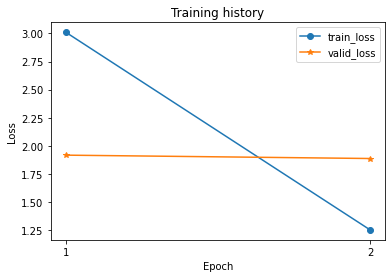

In [ ]:
#損失
plt.plot(history['epoch'],history['train_loss'], label='train_loss',marker="o")
plt.plot(history['epoch'],history['valid_loss'], label='valid_loss',marker="*")
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(history['epoch'])
plt.legend()

In [ ]:
#測試資料處理
import string, re

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)
  def white_space_fix(text):
    return " ".join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)
  # 將字母統一以小寫形式表示
  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

#計算EM Score 函數
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

#計算F1 Score 函數
def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()

  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)

  common_tokens = set(pred_tokens) & set(truth_tokens)

  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0

  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)

  return round(2 * (prec * rec) / (prec + rec), 2)

In [ ]:
#預測函數
def Test(model):
  F1_score=[]
  EM_score=[]
  model=model.eval()
  with torch.no_grad():
    for one in test_dataset:
      question=one['question']
      input_ids=one['input_ids'].to(device)
      attention_mask =one['attention_mask'].to(device)
      outputs = model(input_ids.reshape(1,512),attention_mask.reshape(1,512))
      answer_start_index = outputs.start_logits.argmax(dim=1)
      answer_end_index = outputs.end_logits.argmax(dim=1)

      #predict answer
      predict_answer = tokenizer.decode(one['input_ids'][answer_start_index.item() : answer_end_index.item()+1])

      #truth answer
      truth_answer = one['answer']

      F1_score.append(compute_f1(predict_answer,truth_answer))
      EM_score.append(exact_match(predict_answer,truth_answer))

  return sum(EM_score)/len(EM_score),np.mean(F1_score)

scores=Test(model)
EM,F1=scores
print("Exact match : {}".format(EM))
print("F1 score : {}".format(round(F1,2)))

Exact match : 0.492
F1 score : 0.57


In [ ]:
#開始預測
for one in test_dataset:
  question=one['question']
  input_ids=one['input_ids'].to(device)
  attention_mask =one['attention_mask'].to(device)
  outputs = model(input_ids.reshape(1,512),attention_mask.reshape(1,512))
  answer_start_index = outputs.start_logits.argmax(dim=1)
  answer_end_index = outputs.end_logits.argmax(dim=1)

  #predict answer
  predict_answer = tokenizer.decode(one['input_ids'][answer_start_index.item() : answer_end_index.item()+1])

  #truth answer
  truth_answer = one['answer']

  print("Question : {}".format(question))
  print("True Answer : {}".format(truth_answer))
  print("Pred Answer : {}".format(predict_answer))
  print("Exact match : {}".format(exact_match(predict_answer,truth_answer)))
  print("F1 score : {}\n".format(compute_f1(predict_answer,truth_answer)))
  break

Question : Super Bowl 50 determined the NFL champion for what season?
True Answer : 2015
Pred Answer : 2015
Exact match : True
F1 score : 1.0

